In [2]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
import numpy as np
import sys
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import torch.nn as nn
import re
from tqdm.auto import tqdm
from textblob import TextBlob

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sahil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# importing data
train_data = pd.read_excel("Dataset/training_dataset.xlsx")
val_data = pd.read_excel("Dataset/validation_dataset.xlsx")

In [4]:
# Text cleaning
non_content = ['um','uh','mhm','mm','oh','customer','agent','says']

# Function for removing ncw and trimming beginng and end from text
def remove_ncw_trim(raw_text, additional_noncontent_words):
    
    # Replace periods with spaces (if required)
    raw_text = raw_text.replace('.', ' ')
    
    # Define English stop words (from NLTK)
    stop_words = set(stopwords.words('english'))

    # Extend stop words with your custom non-content words
    stop_words.update(additional_noncontent_words)

    # Remove sequences of 'x's or '*'s
    raw_text = re.sub(r'[x*]+', '', raw_text)

    raw_text = re.sub(r'[^A-Za-z\s]', '', raw_text)

    # Split the text into words using whitespace
    uncut_words = raw_text.split()

    # Filter out the stop words and non-content words
    filtered_words = [word for word in uncut_words if word.lower() not in stop_words]
    
    # Join words back to string
    return ' '.join(filtered_words)


train_data['cleaned_text'] = train_data['text'].apply(lambda x: remove_ncw_trim(x, non_content))
val_data['cleaned_text'] = val_data['text'].apply(lambda x: remove_ncw_trim(x, non_content))

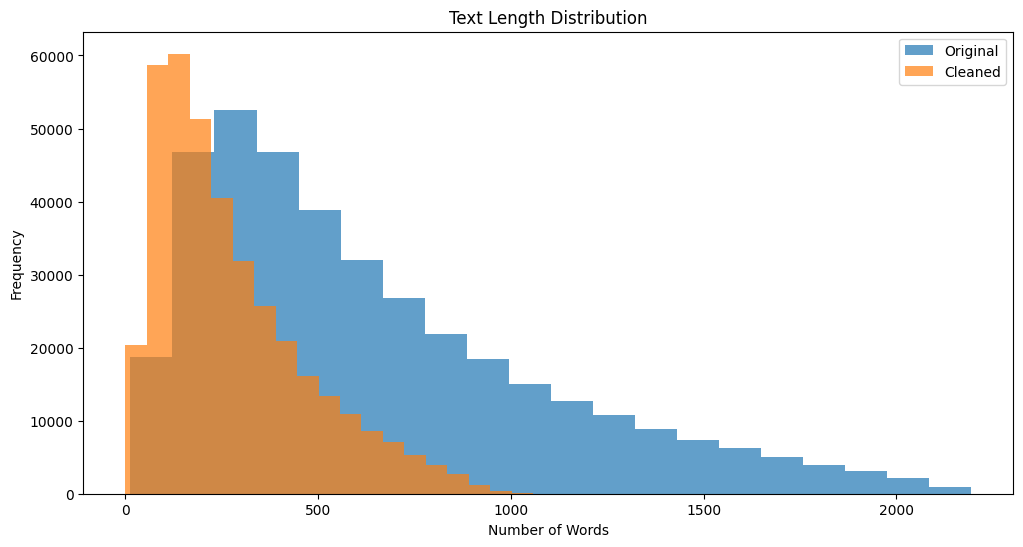

In [5]:
# text preprocessing visualizaton
from sklearn.metrics import precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.hist(train_data['text'].str.split().str.len(), bins=20, alpha=0.7, label='Original')
plt.hist(train_data['cleaned_text'].str.split().str.len(), bins=20, alpha=0.7, label='Cleaned')
plt.title('Text Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend()
plt.show()


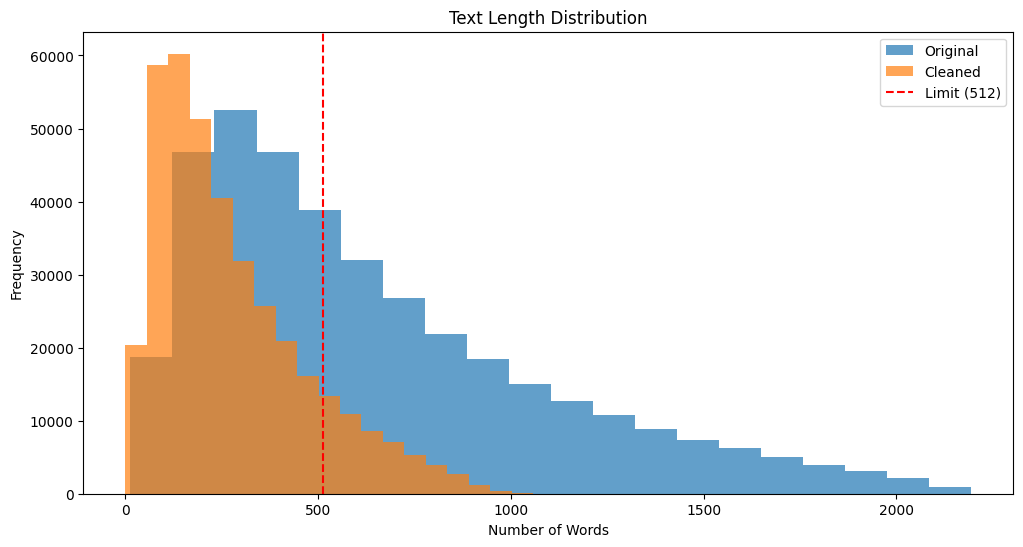

In [6]:
plt.figure(figsize=(12, 6))
plt.hist(train_data['text'].str.split().str.len(), bins=20, alpha=0.7, label='Original')
plt.hist(train_data['cleaned_text'].str.split().str.len(), bins=20, alpha=0.7, label='Cleaned')
plt.axvline(x=512, color='red', linestyle='--', label='Limit (512)')  # Add a vertical line at 512
plt.title('Text Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [7]:
# Function to calculate the percentage of texts above a certain word count threshold
def calculate_percentage_above_threshold(df, original_column, cleaned_column, threshold):
    total_texts = df.shape[0]
    above_threshold_original = df[df[original_column].str.split().str.len() > threshold].shape[0]
    above_threshold_cleaned = df[df[cleaned_column].str.split().str.len() > threshold].shape[0]

    percentage_above_threshold_original = (above_threshold_original / total_texts) * 100
    percentage_above_threshold_cleaned = (above_threshold_cleaned / total_texts) * 100

    return percentage_above_threshold_original, percentage_above_threshold_cleaned

# Apply the function to your dataset
threshold = 512
percentage_above_512_original, percentage_above_512_cleaned = calculate_percentage_above_threshold(train_data, 'text', 'cleaned_text', threshold)

# Print the results
print(f"Percentage of texts above {threshold} words before cleaning: {percentage_above_512_original:.2f}%")
print(f"Percentage of texts above {threshold} words after cleaning: {percentage_above_512_cleaned:.2f}%")



Percentage of texts above 512 words before cleaning: 50.22%
Percentage of texts above 512 words after cleaning: 13.31%


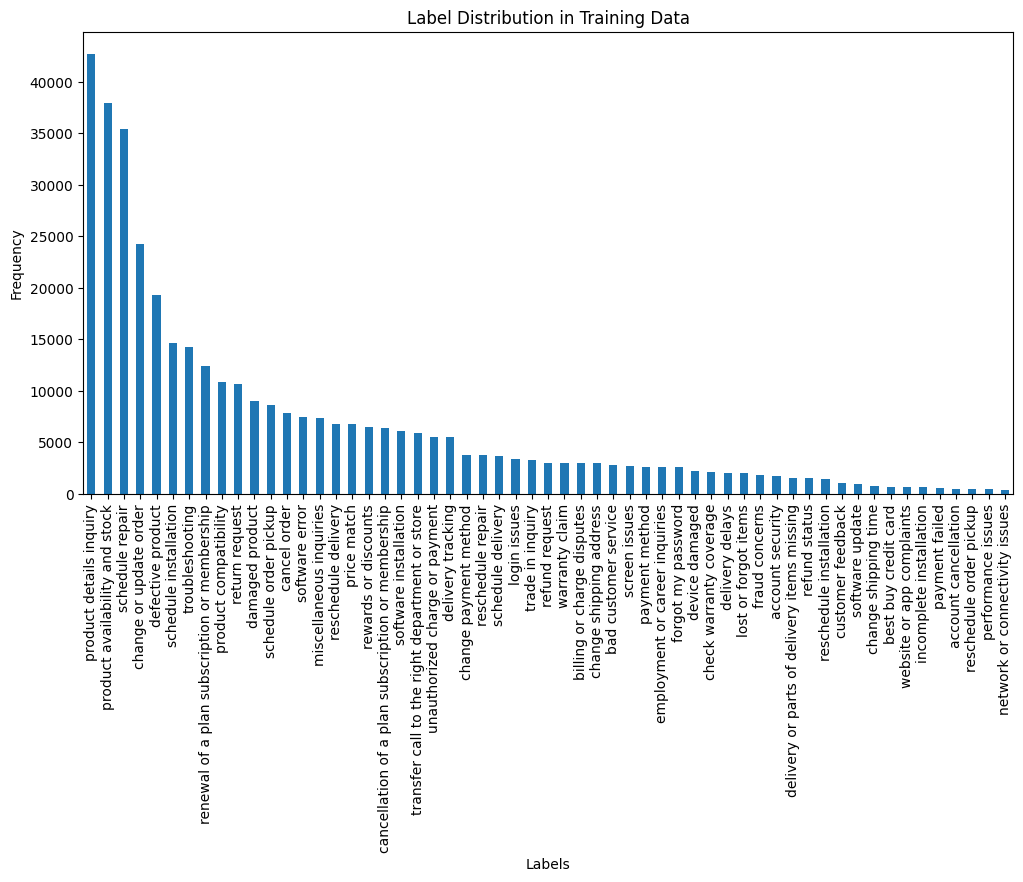

In [8]:
# Label Distribution

train_data['label'].value_counts().plot(kind='bar', figsize=(12, 6))
plt.title('Label Distribution in Training Data')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.show()

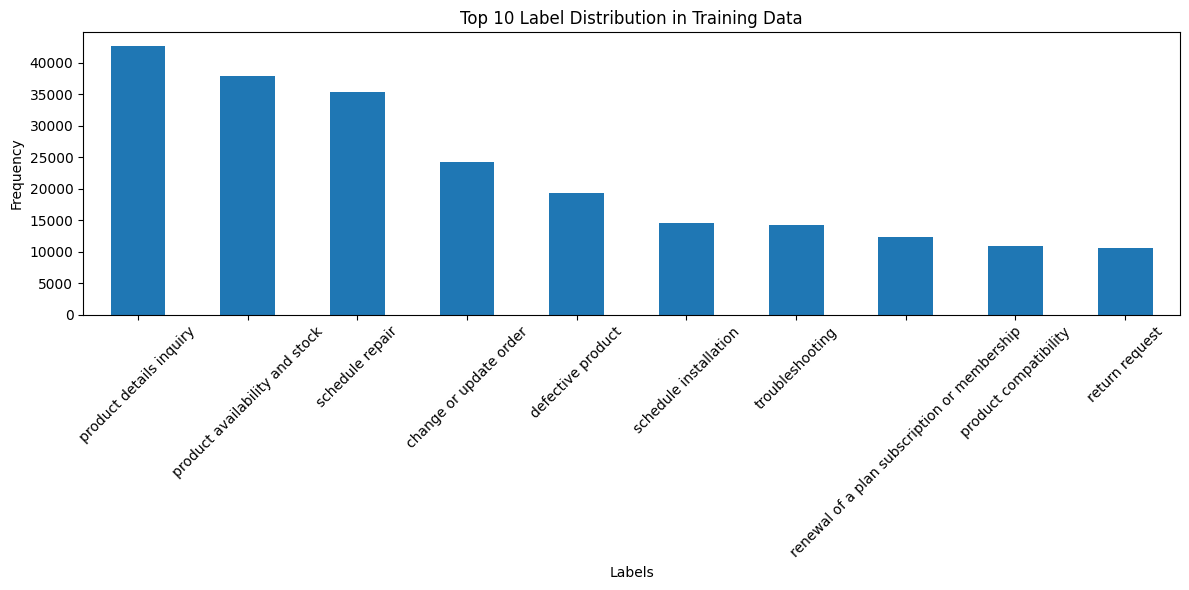

label
product details inquiry                         42698
product availability and stock                  37972
schedule repair                                 35386
change or update order                          24297
defective product                               19269
schedule installation                           14616
troubleshooting                                 14242
renewal of a plan subscription or membership    12402
product compatibility                           10897
return request                                  10634
Name: count, dtype: int64


In [9]:
# Define the number of top labels you want to display
top_n = 10

# Calculate the value counts and keep the top 'n' labels
label_counts = train_data['label'].value_counts().nlargest(top_n)

# Plotting the top 'n' label counts
plt.figure(figsize=(12, 6))
label_counts.plot(kind='bar')
plt.title('Top 10 Label Distribution in Training Data')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate the labels for better readability if needed
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()

# If you want to print the labels and their counts
print(label_counts)

C:\Users\sahil\AppData\Local\Temp\ipykernel_45680\1173174080.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=label_counts.values, y=label_counts.index, palette="Blues_r")


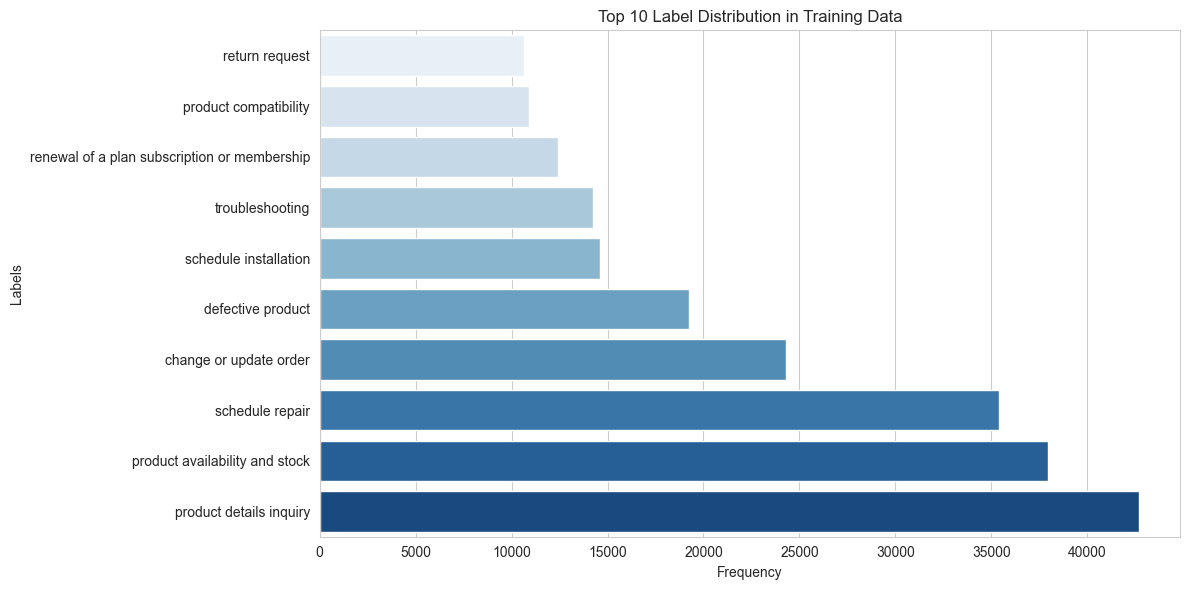

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the number of top labels you want to display
top_n = 10

# Calculate the value counts and keep the top 'n' labels
label_counts = train_data['label'].value_counts().nlargest(top_n)

# Create a more visually appealing bar chart using Seaborn
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
ax = sns.barplot(x=label_counts.values, y=label_counts.index, palette="Blues_r")

# Customize the chart aesthetics
ax.set(xlabel='Frequency', ylabel='Labels')
plt.title('Top 10 Label Distribution in Training Data')
plt.gca().invert_yaxis()  # Invert the y-axis for better readability

# Add data labels to the bars
for p in ax.patches:
    width = p.get_width()
    # plt.text(width + 5, p.get_y() + p.get_height() / 2, f'{width}', ha='center', va='center')

plt.tight_layout()
plt.show()


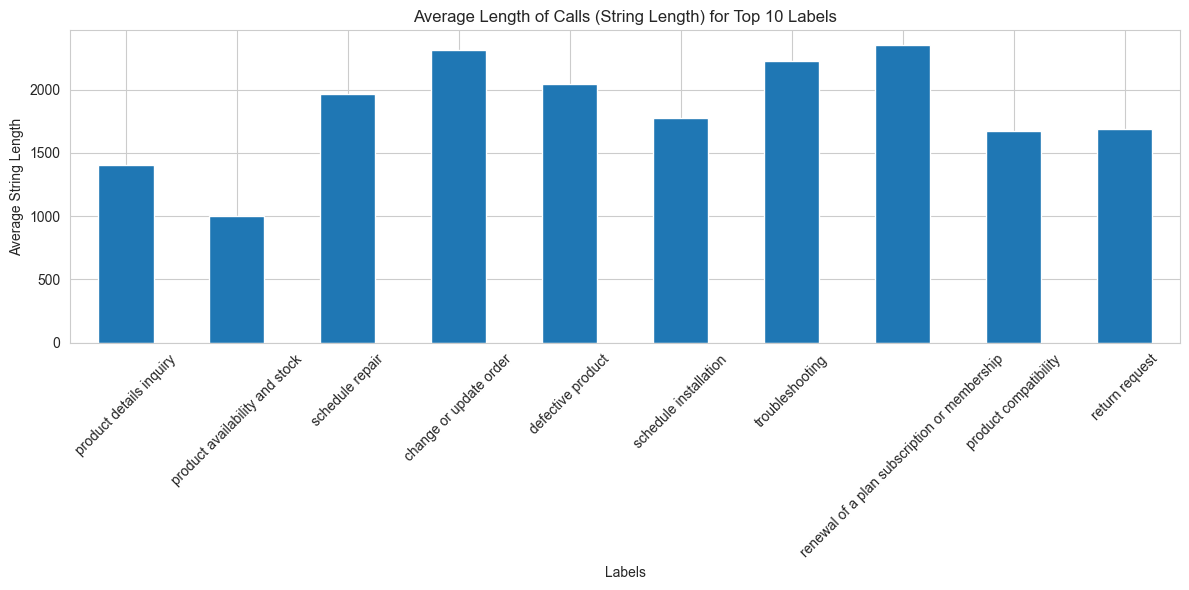

In [11]:
# Group the data by the 'label' column
label_groups = train_data.groupby('label')

# Calculate the average string length of the 'cleaned_text' column for each label group
average_string_lengths_cleaned = label_groups['cleaned_text'].apply(lambda x: x.str.len().mean())

# Select the top 10 labels based on their frequency
top_n_labels = label_counts.index[:top_n]

# Filter the average string lengths for the top 10 labels
top_n_average_string_lengths_cleaned = average_string_lengths_cleaned[top_n_labels]

# Plot a bar graph for the top 10 labels and their average string lengths of cleaned text
plt.figure(figsize=(12, 6))
top_n_average_string_lengths_cleaned.plot(kind='bar')
plt.title('Average Length of Calls (String Length) for Top 10 Labels')
plt.xlabel('Labels')
plt.ylabel('Average String Length')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



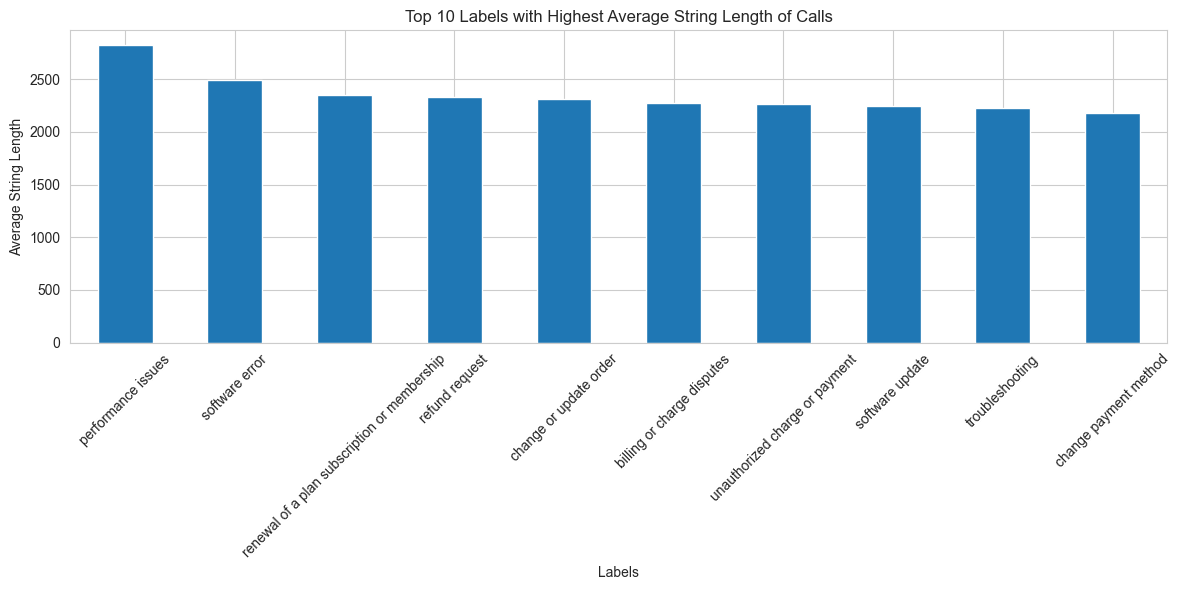

In [12]:
# Calculate the average string length of the 'cleaned_text' column for each label group
average_string_lengths_cleaned = label_groups['cleaned_text'].apply(lambda x: x.str.len().mean())

# Sort the labels based on average string length in descending order
sorted_labels = average_string_lengths_cleaned.sort_values(ascending=False)

# Select the top 10 labels with the highest average string lengths
top_10_highest_length_labels = sorted_labels[:10]

# Plot a bar graph for the top 10 labels with the highest average string lengths
plt.figure(figsize=(12, 6))
top_10_highest_length_labels.plot(kind='bar')
plt.title('Top 10 Labels with Highest Average String Length of Calls')
plt.xlabel('Labels')
plt.ylabel('Average String Length')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\sahil\AppData\Local\Temp\ipykernel_45680\125187958.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=top_10_highest_length_labels.values, y=top_10_highest_length_labels.index, palette="viridis")


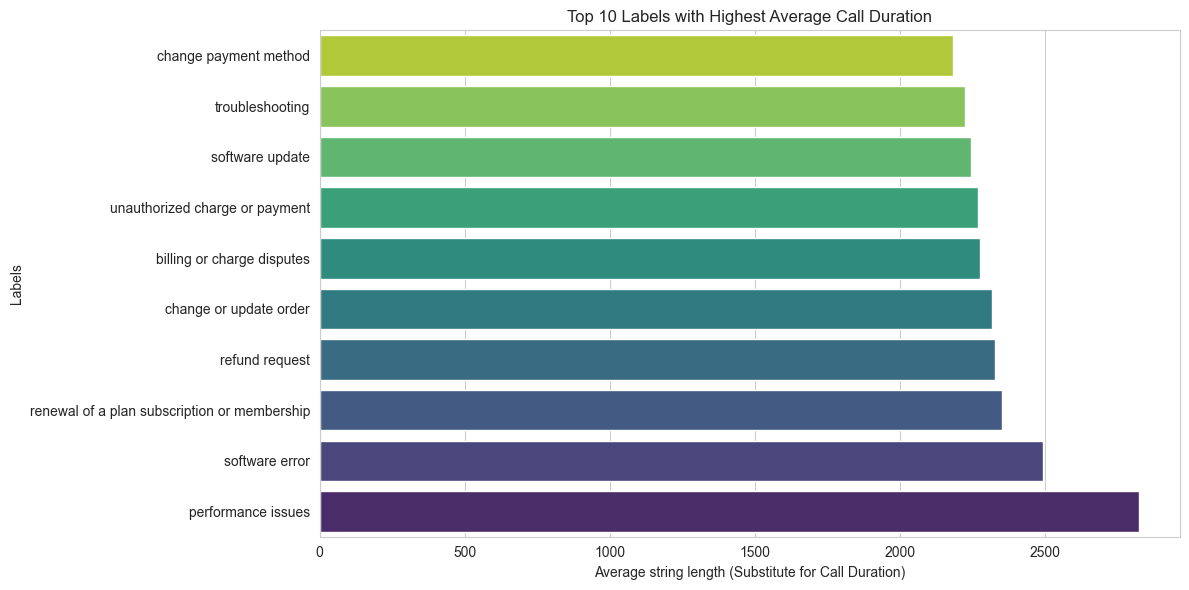

In [13]:
# Calculate the average string length of the 'cleaned_text' column for each label group
average_string_lengths_cleaned = label_groups['cleaned_text'].apply(lambda x: x.str.len().mean())

# Sort the labels based on average string length in descending order
sorted_labels = average_string_lengths_cleaned.sort_values(ascending=False)

# Select the top 10 labels with the highest average string lengths
top_10_highest_length_labels = sorted_labels[:10]

# Create a more visually appealing bar chart using Seaborn
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
ax = sns.barplot(x=top_10_highest_length_labels.values, y=top_10_highest_length_labels.index, palette="Blues_r")

# Add labels and titles
ax.set(xlabel='Average string length (Substitute for Call Duration)', ylabel='Labels')
plt.title('Top 10 Labels with Highest Average Call Duration')

# Invert the y-axis for better readability
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()


In [14]:
# SENTIMENT ANALYSIS TEXTBLOB

In [15]:
from textblob import TextBlob
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Initialize tqdm for pandas apply
tqdm.pandas()

# Function to calculate sentiment polarity using TextBlob
def calculate_sentiment_textblob(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

# Apply TextBlob sentiment analysis
train_data['sentiment_polarity'] = train_data['cleaned_text'].progress_apply(calculate_sentiment_textblob)

# Classify the tone based on polarity
train_data['tone_textblob'] = train_data['sentiment_polarity'].apply(lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'neutral'))

  0%|          | 0/379328 [00:00<?, ?it/s]

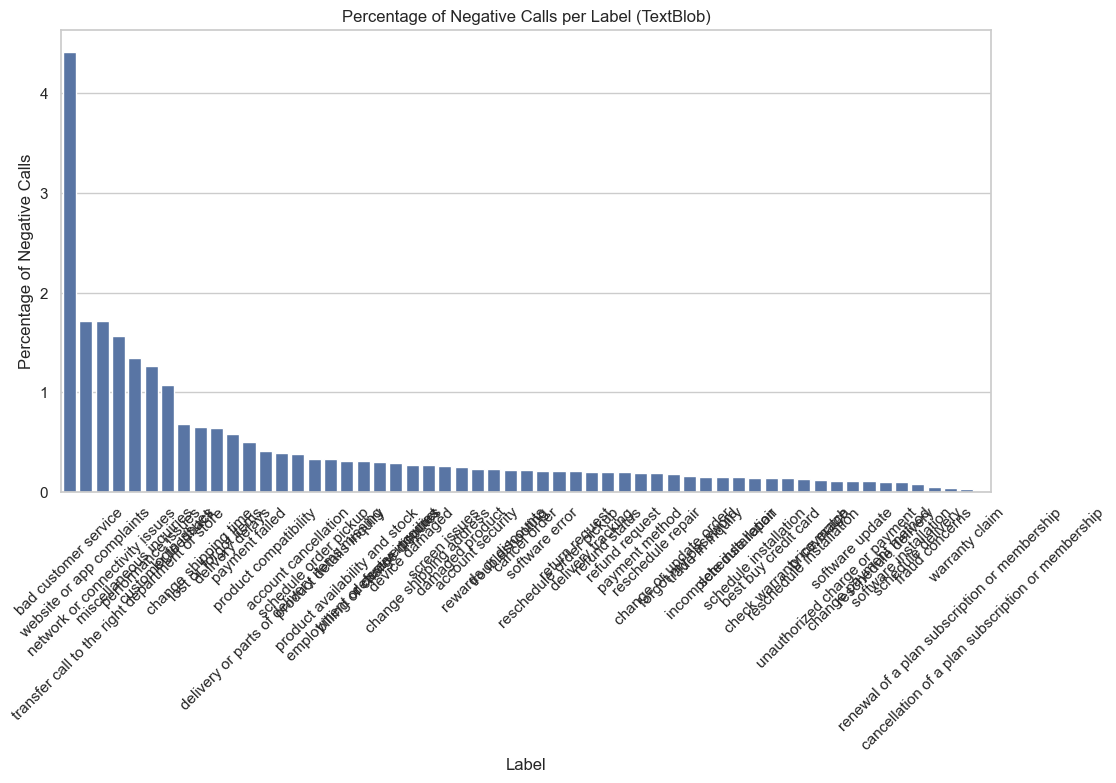

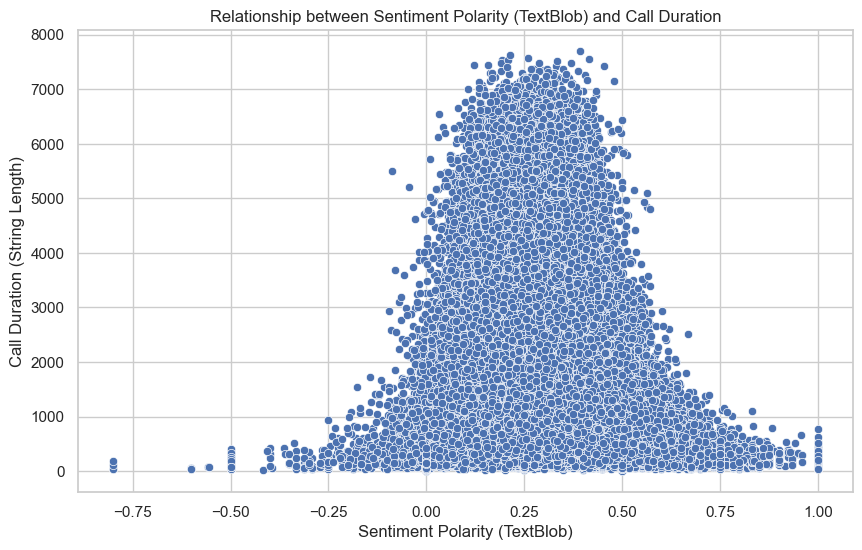

Pearson's correlation (TextBlob): -0.2249417625871562
                                                text                    label  \
0  agent says sir before sir. may i have your nam...  miscellaneous inquiries   
1  agent says team best buy this is name before i...  miscellaneous inquiries   
2  customer says experience there was..customer s...     bad customer service   
3  customer says i dont know. now its up and runn...  miscellaneous inquiries   
4  agent says mhm.agent says yeah..customer says ...  miscellaneous inquiries   

                                        cleaned_text  sentiment_polarity  \
0  sir sir may name phone number please purley nu...            0.000000   
1  team best buy name begin may please full name ...            0.566667   
2  eperience hello well problem ever happen someb...            0.333333   
3  dont know running think got rid emails maybe s...            0.500000   
4  yeah hello hello yeah come hello hello thanks ...            0.350000   

  

In [16]:
def calculate_negative_percentage(df, sentiment_column, label_column):
    negative_counts = df[df[sentiment_column] == 'negative'].groupby(label_column).size()
    total_counts = df.groupby(label_column).size()
    negative_percentage = (negative_counts / total_counts) * 100
    negative_percentage = negative_percentage.fillna(0)  # Fill NaN values with 0
    return negative_percentage.sort_values(ascending=False)

# Calculate the percentage of negative calls using TextBlob results
negative_percentage_textblob = calculate_negative_percentage(train_data, 'tone_textblob', 'label')

# Plotting the percentage of negative calls per label (TextBlob)
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(x=negative_percentage_textblob.index, y=negative_percentage_textblob.values)
plt.title('Percentage of Negative Calls per Label (TextBlob)')
plt.xlabel('Label')
plt.ylabel('Percentage of Negative Calls')
plt.xticks(rotation=45)
plt.show()

# Calculate string length as a proxy for call duration
train_data['string_length'] = train_data['cleaned_text'].apply(len)

# Scatter plot and correlation for TextBlob sentiment polarity
plt.figure(figsize=(10, 6))
sns.scatterplot(x='sentiment_polarity', y='string_length', data=train_data)
plt.title('Relationship between Sentiment Polarity (TextBlob) and Call Duration')
plt.xlabel('Sentiment Polarity (TextBlob)')
plt.ylabel('Call Duration (String Length)')
plt.show()

# Calculate Pearson's correlation
correlation_textblob, p_value_textblob = stats.pearsonr(train_data['sentiment_polarity'], train_data['string_length'])
print(f"Pearson's correlation (TextBlob): {correlation_textblob}")

# Display the first few rows of the DataFrame
print(train_data.head(5))

C:\Users\sahil\AppData\Local\Temp\ipykernel_45680\2912635009.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_20_labels_negative_percentage.values, y=top_20_labels_negative_percentage.index, palette="viridis")


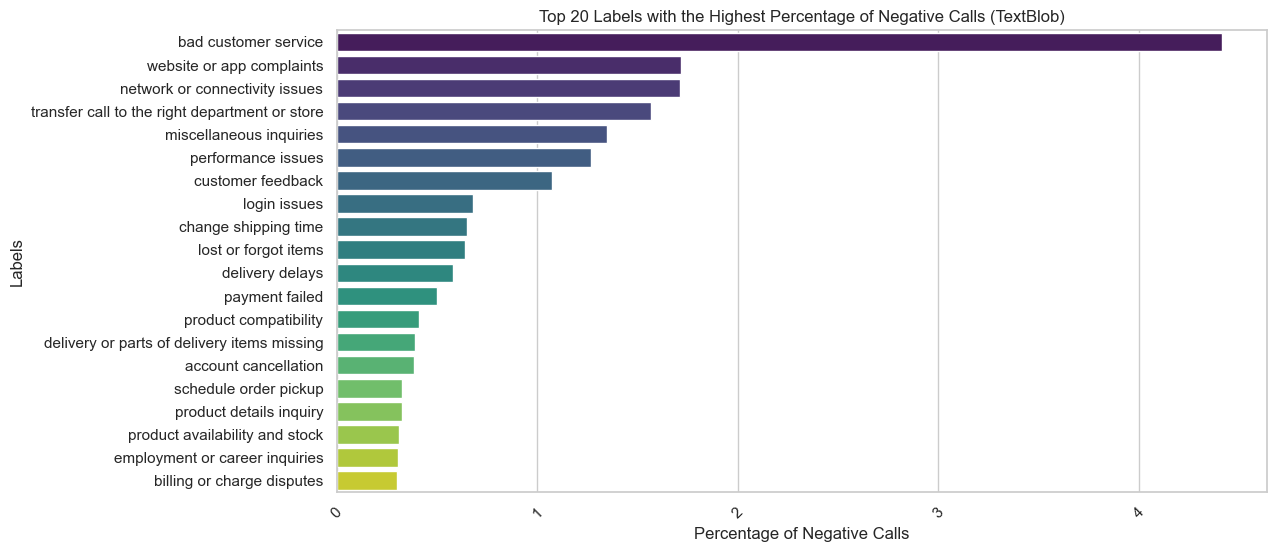

In [17]:
# Calculate the percentage of negative calls using TextBlob results
negative_percentage_textblob = calculate_negative_percentage(train_data, 'tone_textblob', 'label')

# Get the top 20 labels with the highest percentage of negative calls
top_20_labels_negative_percentage = negative_percentage_textblob.nlargest(20)

# Plotting the top 20 labels with the highest percentage of negative calls (TextBlob)
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
# Ensure that the data is sorted correctly here before plotting
sns.barplot(x=top_20_labels_negative_percentage.values, y=top_20_labels_negative_percentage.index, palette="viridis")

plt.title('Top 20 Labels with the Highest Percentage of Negative Calls (TextBlob)')
plt.xlabel('Percentage of Negative Calls')
plt.ylabel('Labels')
plt.xticks(rotation=45)  # Rotate the x-labels if necessary
plt.show()

C:\Users\sahil\AppData\Local\Temp\ipykernel_45680\2172199746.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_10_negative_percentage.index, x=top_10_negative_percentage.values, palette="coolwarm", orient='h')


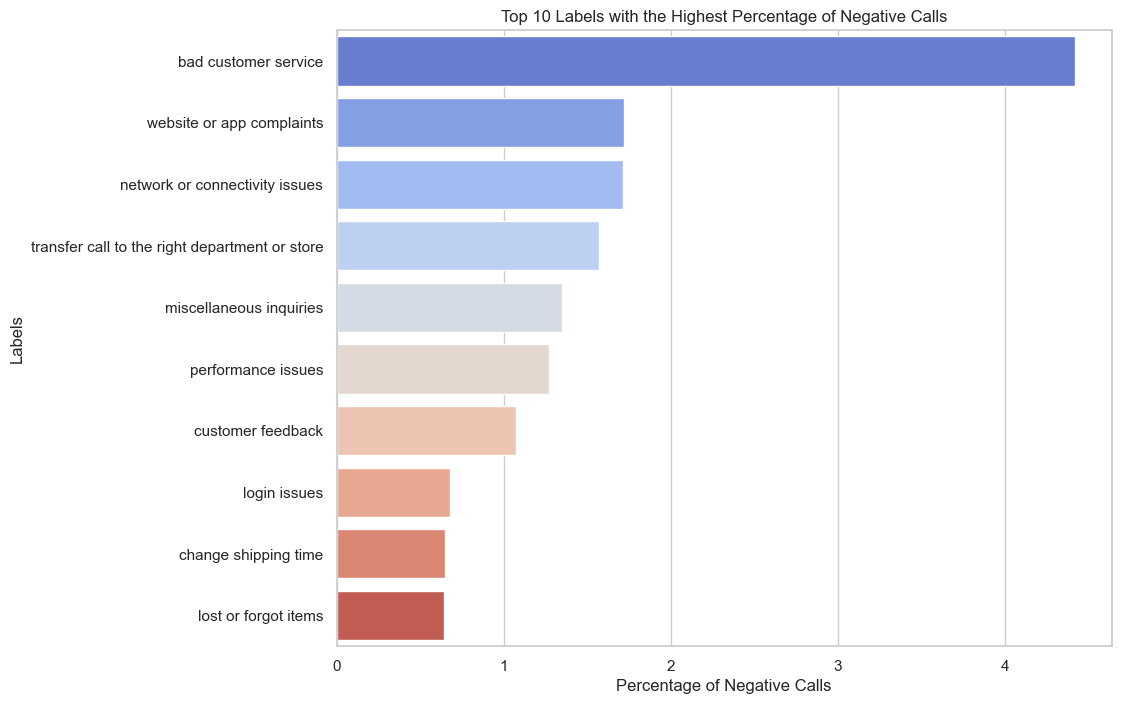

In [18]:
# First, we need to calculate the percentage of negative calls for each label
negative_counts = train_data[train_data['tone_textblob'] == 'negative']['label'].value_counts()
total_counts = train_data['label'].value_counts()
negative_percentage = (negative_counts / total_counts * 100).sort_values(ascending=False)

# Now we select the top 10 labels with the highest percentage of negative calls
top_10_negative_percentage = negative_percentage.head(10)

# Plotting the top 10 labels with the highest percentage of negative calls
plt.figure(figsize=(10, 8))
sns.barplot(y=top_10_negative_percentage.index, x=top_10_negative_percentage.values, palette="coolwarm", orient='h')
plt.title('Top 10 Labels with the Highest Percentage of Negative Calls')
plt.xlabel('Percentage of Negative Calls')
plt.ylabel('Labels')
plt.show()

C:\Users\sahil\AppData\Local\Temp\ipykernel_45680\3478939881.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y=top_10_labels_negative_percentage.index, x=top_10_labels_negative_percentage.values, palette="viridis")


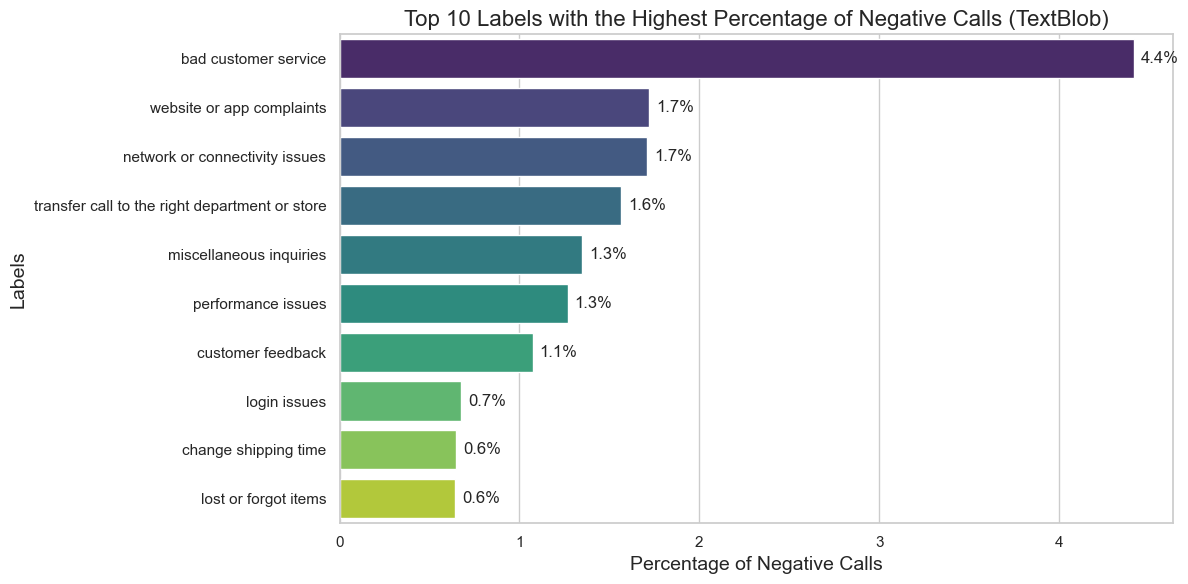

In [19]:
# Calculate the percentage of negative calls using TextBlob results
negative_percentage_textblob = calculate_negative_percentage(train_data, 'tone_textblob', 'label')

# Get the top 10 labels with the highest percentage of negative calls
top_10_labels_negative_percentage = negative_percentage_textblob.nlargest(10)

# Plotting the top 10 labels with the highest percentage of negative calls (TextBlob)
plt.figure(figsize=(12, 6))
ax = sns.barplot(y=top_10_labels_negative_percentage.index, x=top_10_labels_negative_percentage.values, palette="viridis")
ax.set_title('Top 10 Labels with the Highest Percentage of Negative Calls (TextBlob)', fontsize=16)
ax.set_xlabel('Percentage of Negative Calls', fontsize=14)
ax.set_ylabel('Labels', fontsize=14)
# Adding the percentage values on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_width():.1f}%', 
                (p.get_width(), p.get_y() + p.get_height() / 2.), 
                ha = 'left', va = 'center', 
                size=12, xytext = (5, 0), 
                textcoords = 'offset points')
plt.tight_layout()
plt.show()

In [45]:
# Export to Excel
train_data.to_excel('textblob_and_visualization_v0.2sb.xlsx', index=False) 